<a href="https://colab.research.google.com/github/PawelJakubczyk/mln_music_preferences/blob/main/Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sorce

https://www.kaggle.com/datasets/miroslavsabo/young-people-survey?select=responses.csv

# Install Libraries

In [1]:
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install concurrent

ERROR: Could not find a version that satisfies the requirement concurrent (from versions: none)
ERROR: No matching distribution found for concurrent


# Import Libraries

In [2]:
# Typing
from typing import Set, List, Dict, Any

# Data
import numpy as np
import pandas as pd

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno

# Data preprocessing
from re import sub
import string

from nltk import download, word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Machine Learning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score


# Define Functions

In [135]:
def generate_prime_numbers(start: int, amount: int) -> List[int]:
    """Generates a list of prime numbers."""
    prime_numbers = []

    def is_prime(n: int) -> bool:
        """Checks if a number is prime."""
        if n > 1:
            for i in range(2, int(n**0.5) + 1):
                if (n % i) == 0:
                    return False
            return True
        return False

    current_number = start
    while len(prime_numbers) < amount:
        if is_prime(current_number):
            prime_numbers.append(current_number)
        current_number += 1

    return prime_numbers

def reorder_column_to_first_place(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """Reorders DataFrame columns with the specified column at the first place."""
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
    new_column_order = [column] + [col for col in df.columns if col != column]
    return df[new_column_order]

def multiply_columns_by_list(df: pd.DataFrame, multiplier_list: List[int]) -> pd.DataFrame:
    """Multiplies each column in the DataFrame by the corresponding value in the multiplier list."""
    if len(df.columns) != len(multiplier_list):
        raise ValueError("Number of columns in DataFrame must match the length of the multiplier list.")
    df = df.mul(multiplier_list)
    return df

def prepare_data(df: pd.DataFrame, target_column: str, new_column_name: str, prime_numbers: List[int]) -> pd.DataFrame:
    """Prepares the DataFrame by reordering columns, multiplying, and concatenating values."""
    df_processed = reorder_column_to_first_place(df, target_column)
    df_processed = df_processed.iloc[:, :-3]
    df_processed = multiply_columns_by_list(df_processed, prime_numbers)
    columns_to_concat = df_processed.columns.difference([target_column])
    df_processed[new_column_name] = df_processed[columns_to_concat].apply(lambda row: ' '.join(map(str, row)), axis=1)
    df_processed = df_processed.drop(df_processed.columns[1:20], axis=1)
    return df_processed

def clean_empty_data(df: pd.DataFrame, columns_to_check: List[str]) -> pd.DataFrame:
    """Cleans the input DataFrame by removing rows with incorrect or invalid values."""
    cleaned_df = df.copy()
    for column in columns_to_check:
        cleaned_df = cleaned_df[cleaned_df[column].notna()]
        cleaned_df = cleaned_df[cleaned_df[column] != ""]
    return cleaned_df

def map_values(df: pd.DataFrame, column: str, value_map: Dict[Any, Any]) -> pd.DataFrame:
    """Map values in the specified DataFrame column according to the provided mapping."""
    df[column] = df[column].map(value_map)
    return df

In [4]:
gender_map = {'female': 0, 'male': 1}

alcohol_map = {'never': 0, 'social drinker': 1, 'drink a lot': 2}

education_map = {
    'currently a primary school pupil': 0,
    'primary school': 1,
    'secondary school': 2,
    'college/bachelor degree': 3,
    'masters degree': 4,
    'doctorate degree': 5
}


# Read the data from a CSV file

In [95]:
df_data = pd.read_csv('responses.csv')
df_data.head(10)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow
5,5.0,3.0,2.0,3.0,2.0,3.0,3.0,2.0,5.0,5.0,...,20.0,186.0,77.0,1.0,male,right handed,secondary school,no,city,block of flats
6,5.0,5.0,5.0,3.0,1.0,2.0,2.0,5.0,3.0,1.0,...,20.0,177.0,50.0,1.0,female,right handed,secondary school,no,village,house/bungalow
7,5.0,3.0,3.0,2.0,1.0,2.0,2.0,4.0,5.0,1.0,...,19.0,184.0,90.0,1.0,male,right handed,college/bachelor degree,no,city,house/bungalow
8,5.0,3.0,3.0,1.0,1.0,2.0,4.0,3.0,5.0,5.0,...,18.0,166.0,55.0,1.0,female,right handed,secondary school,no,city,house/bungalow
9,5.0,3.0,2.0,5.0,2.0,2.0,5.0,3.0,5.0,2.0,...,19.0,174.0,60.0,3.0,female,right handed,secondary school,no,city,block of flats


### Select data to analise

In [96]:
df_music = df_data.iloc[:,0:19]
df_music["Gender"] = df_data["Gender"]
df_music["Age"] = df_data["Age"]
df_music["Alcohol"] = df_data["Alcohol"]
df_music["Education"] = df_data["Education"]

df_music.head(10)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,"Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Gender,Age,Alcohol,Education
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,1.0,3.0,1.0,1.0,1.0,1.0,female,20.0,drink a lot,college/bachelor degree
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,1.0,4.0,4.0,2.0,1.0,1.0,female,19.0,drink a lot,college/bachelor degree
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,3.0,5.0,5.0,5.0,1.0,3.0,female,20.0,drink a lot,secondary school
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,1.0,2.0,5.0,1.0,2.0,1.0,female,22.0,drink a lot,college/bachelor degree
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,2.0,1.0,2.0,4.0,2.0,2.0,female,20.0,social drinker,secondary school
5,5.0,3.0,2.0,3.0,2.0,3.0,3.0,2.0,5.0,5.0,...,4.0,4.0,5.0,3.0,1.0,3.0,male,20.0,never,secondary school
6,5.0,5.0,5.0,3.0,1.0,2.0,2.0,5.0,3.0,1.0,...,1.0,2.0,3.0,3.0,5.0,2.0,female,20.0,social drinker,secondary school
7,5.0,3.0,3.0,2.0,1.0,2.0,2.0,4.0,5.0,1.0,...,2.0,3.0,1.0,2.0,3.0,2.0,male,19.0,drink a lot,college/bachelor degree
8,5.0,3.0,3.0,1.0,1.0,2.0,4.0,3.0,5.0,5.0,...,2.0,2.0,NaN,1.0,1.0,1.0,female,18.0,social drinker,secondary school
9,5.0,3.0,2.0,5.0,2.0,2.0,5.0,3.0,5.0,2.0,...,4.0,4.0,4.0,5.0,1.0,2.0,female,19.0,drink a lot,secondary school


# Analise and Preprocesing Data

### Show full data counts

In [97]:
df_music.Music.value_counts()

5.0    822
4.0    129
3.0     36
2.0     11
1.0      9
Name: Music, dtype: int64

In [98]:
print(df_music.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Music                     1007 non-null   float64
 1   Slow songs or fast songs  1008 non-null   float64
 2   Dance                     1006 non-null   float64
 3   Folk                      1005 non-null   float64
 4   Country                   1005 non-null   float64
 5   Classical music           1003 non-null   float64
 6   Musical                   1008 non-null   float64
 7   Pop                       1007 non-null   float64
 8   Rock                      1004 non-null   float64
 9   Metal or Hardrock         1007 non-null   float64
 10  Punk                      1002 non-null   float64
 11  Hiphop, Rap               1006 non-null   float64
 12  Reggae, Ska               1003 non-null   float64
 13  Swing, Jazz               1004 non-null   float64
 14  Rock n r

In [99]:
print(df_music.isnull().sum())

Music                       3
Slow songs or fast songs    2
Dance                       4
Folk                        5
Country                     5
Classical music             7
Musical                     2
Pop                         3
Rock                        6
Metal or Hardrock           3
Punk                        8
Hiphop, Rap                 4
Reggae, Ska                 7
Swing, Jazz                 6
Rock n roll                 7
Alternative                 7
Latino                      8
Techno, Trance              7
Opera                       1
Gender                      6
Age                         7
Alcohol                     5
Education                   1
dtype: int64


In [100]:
df_music = clean_empty_data(df_music, ['Education', 'Alcohol', 'Age', 'Gender'])
df_music.fillna(3, inplace=True)
df_music.reset_index(drop=True,inplace=True)

print(df_music.isnull().sum())

Music                       0
Slow songs or fast songs    0
Dance                       0
Folk                        0
Country                     0
Classical music             0
Musical                     0
Pop                         0
Rock                        0
Metal or Hardrock           0
Punk                        0
Hiphop, Rap                 0
Reggae, Ska                 0
Swing, Jazz                 0
Rock n roll                 0
Alternative                 0
Latino                      0
Techno, Trance              0
Opera                       0
Gender                      0
Age                         0
Alcohol                     0
Education                   0
dtype: int64


### Show full data counts

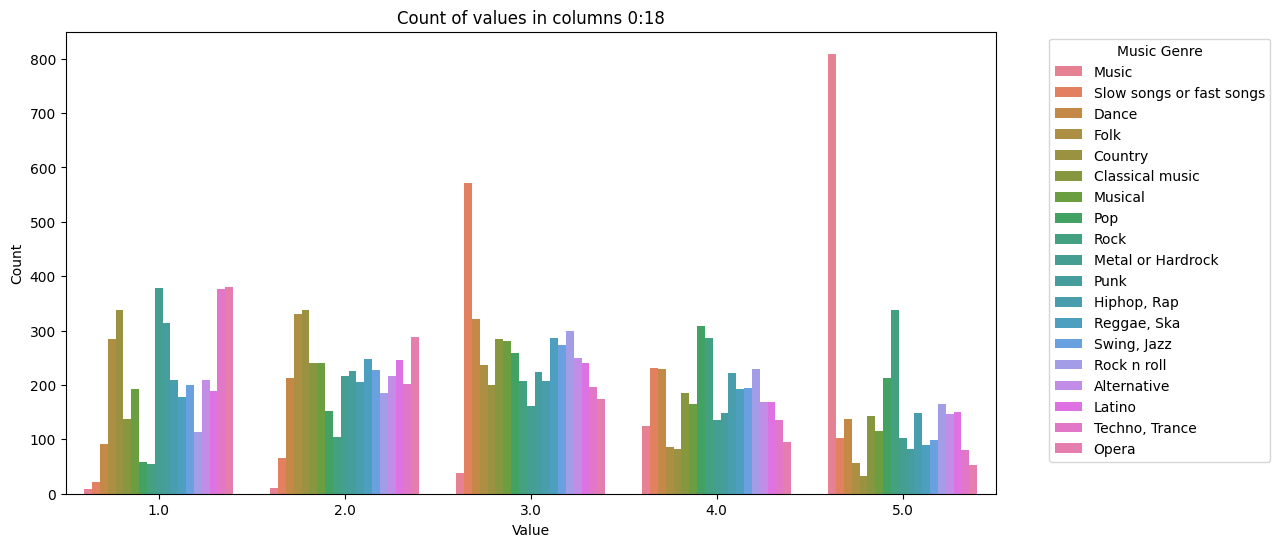

In [101]:
# Selecting the first 19 columns with music
selected_columns = df_music.iloc[:, :19]

# Transforming data using melt
melted_data = pd.melt(selected_columns)

# Creating a countplot
plt.figure(figsize=(12, 6))
sns.countplot(x='value', hue='variable', data=melted_data)

plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Count of values in columns 0:18')

# Placing the legend outside the plot
plt.legend(title='Music Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()

## Converted The gender, alkochol, education data to integers to process data easily
**gender:**
- female: 0
- male: 1

**alcohol:**
- never: 0
- social drinker: 1
- drink a lot: 2

**education:**
- currently a primary school pupil: 0
- primary school: 1
- secondary school: 2
- college/bachelor degree: 3
- masters degree: 4
- doctorate degree: 5

In [102]:
df_music = map_values(df_music, "Gender", gender_map)
df_music = map_values(df_music, "Alcohol", alcohol_map)
df_music = map_values(df_music, "Education", education_map)

## Change the column type to more optimal ones

In [103]:
print(df_music.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Music                     992 non-null    float64
 1   Slow songs or fast songs  992 non-null    float64
 2   Dance                     992 non-null    float64
 3   Folk                      992 non-null    float64
 4   Country                   992 non-null    float64
 5   Classical music           992 non-null    float64
 6   Musical                   992 non-null    float64
 7   Pop                       992 non-null    float64
 8   Rock                      992 non-null    float64
 9   Metal or Hardrock         992 non-null    float64
 10  Punk                      992 non-null    float64
 11  Hiphop, Rap               992 non-null    float64
 12  Reggae, Ska               992 non-null    float64
 13  Swing, Jazz               992 non-null    float64
 14  Rock n rol

In [104]:
for each in range(0,23) :
  df_music[df_music.columns[each]] = df_music[df_music.columns[each]].astype('i2')
print(df_music.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Music                     992 non-null    int16
 1   Slow songs or fast songs  992 non-null    int16
 2   Dance                     992 non-null    int16
 3   Folk                      992 non-null    int16
 4   Country                   992 non-null    int16
 5   Classical music           992 non-null    int16
 6   Musical                   992 non-null    int16
 7   Pop                       992 non-null    int16
 8   Rock                      992 non-null    int16
 9   Metal or Hardrock         992 non-null    int16
 10  Punk                      992 non-null    int16
 11  Hiphop, Rap               992 non-null    int16
 12  Reggae, Ska               992 non-null    int16
 13  Swing, Jazz               992 non-null    int16
 14  Rock n roll               992 non-null    

## Create correlation matrix

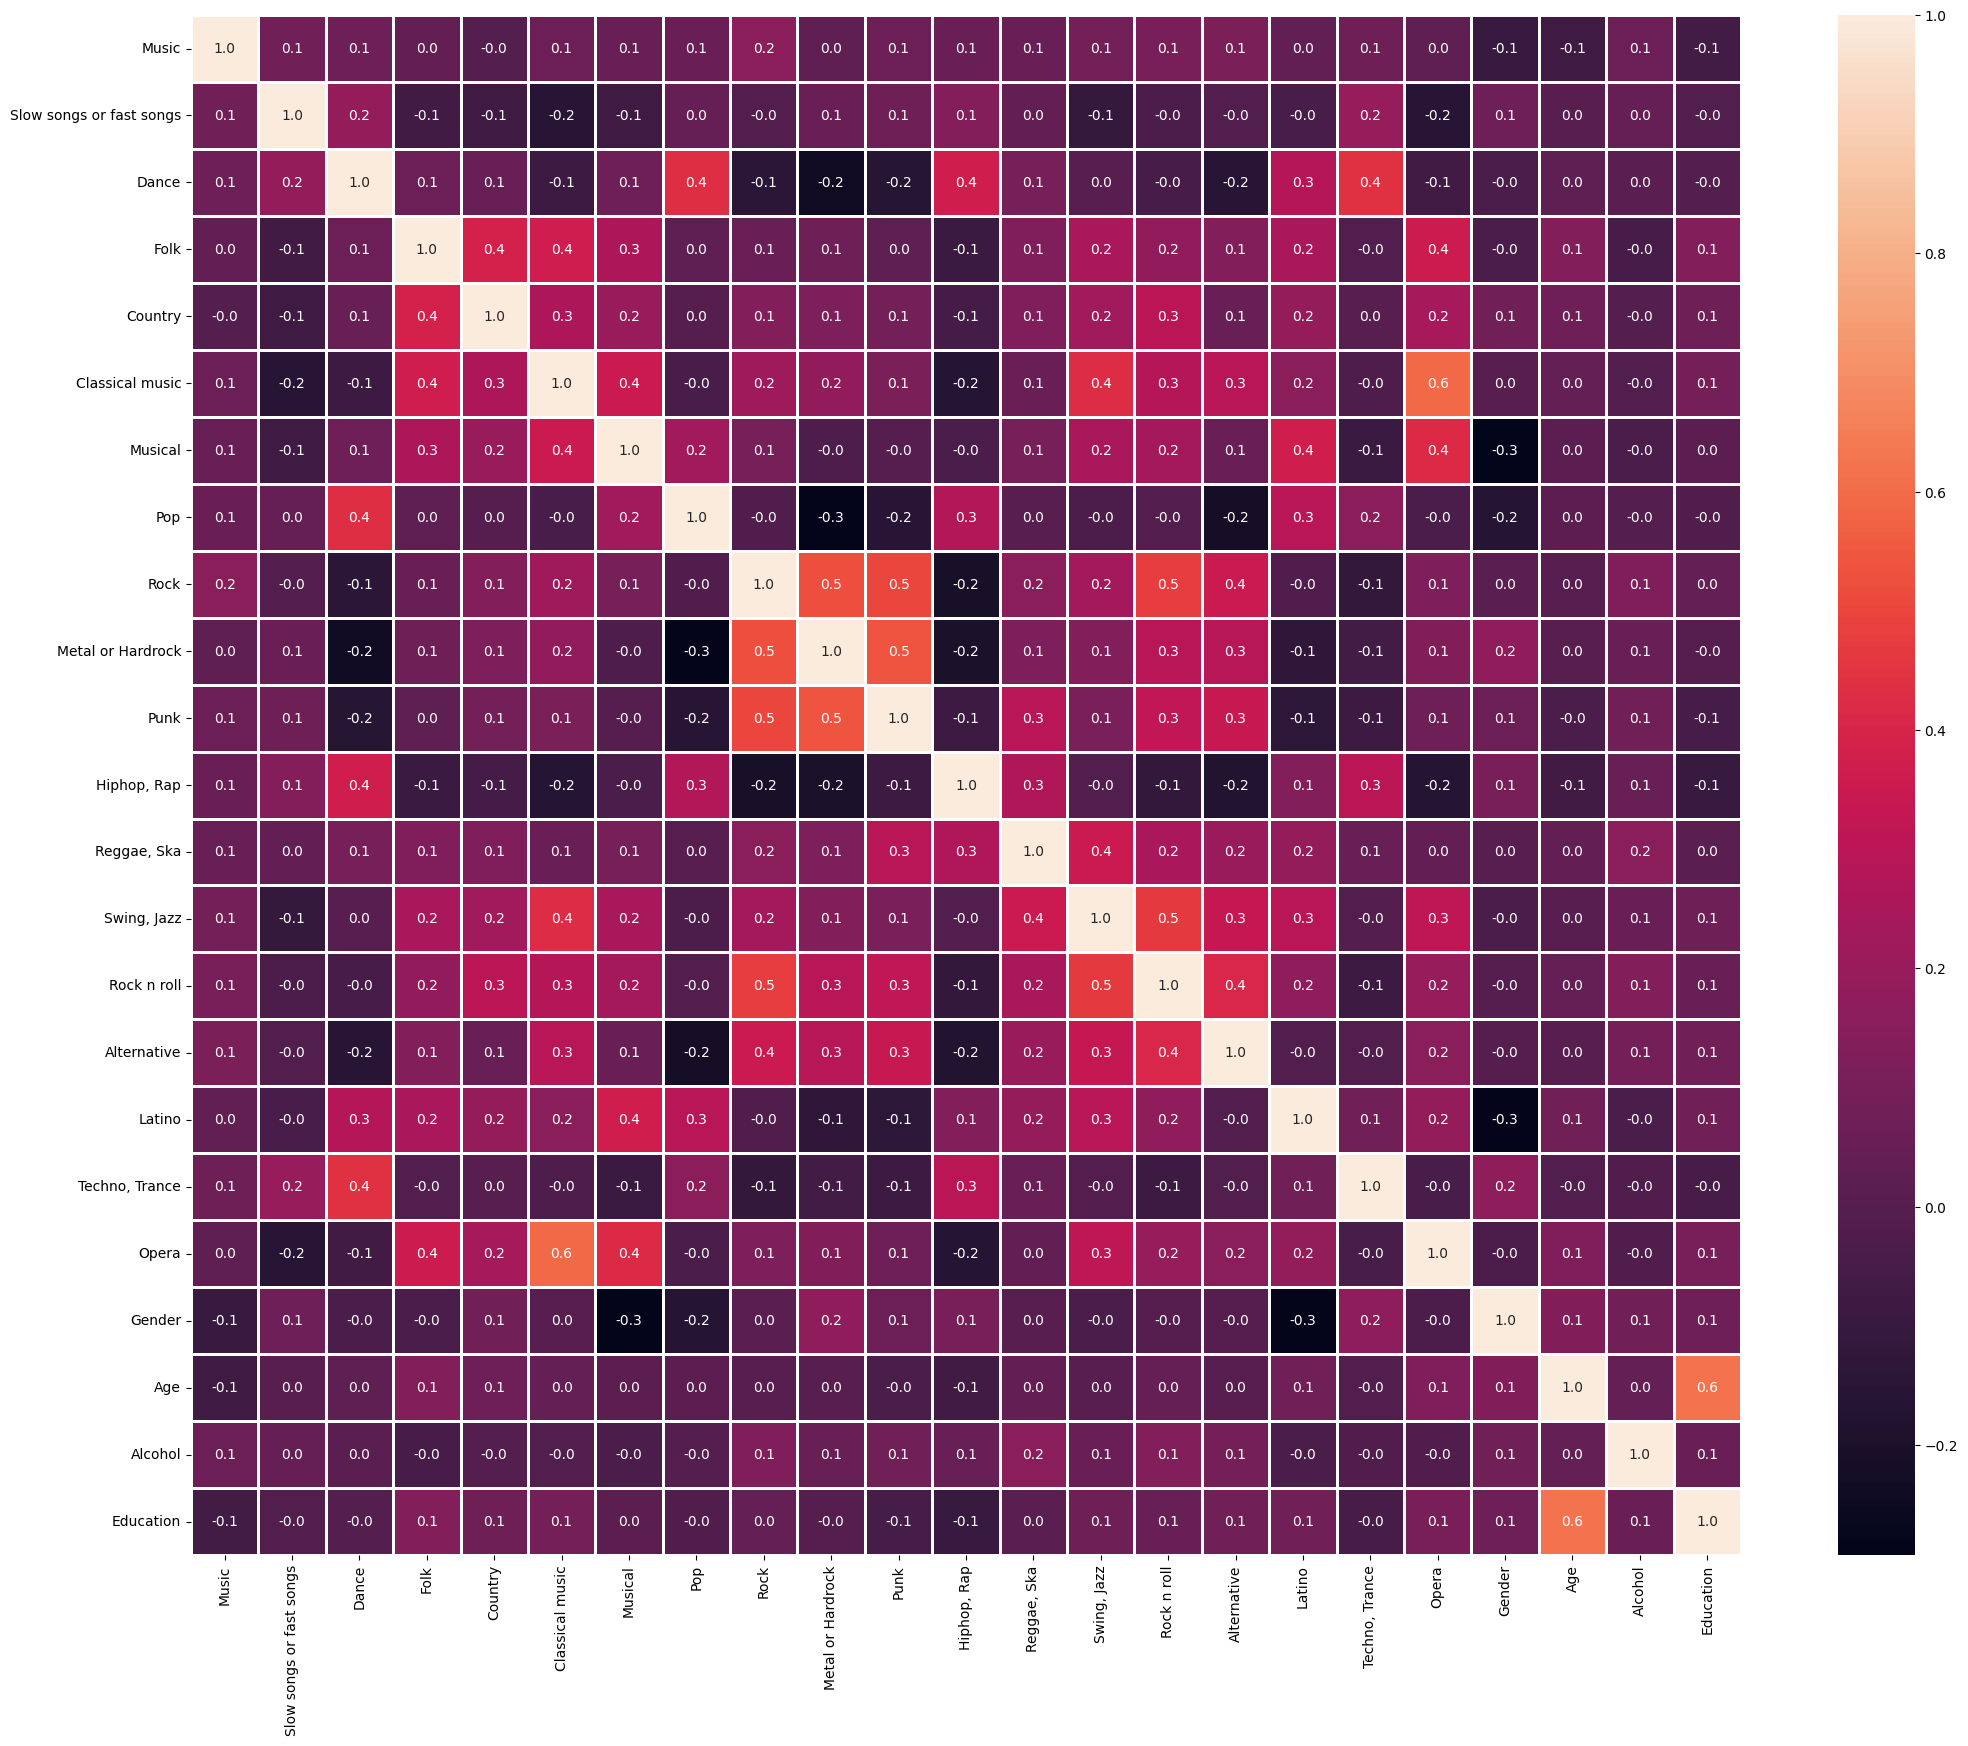

In [105]:
correlation_matrix = df_music.corr()
f,ax = plt.subplots(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=True, linewidths=1, fmt= '.1f',ax=ax)
plt.show()

### correlations for the most important columns

In [106]:
def get_correlation_for_column(df, column_for_correlation):
    df_correlation_matrix = df.corr()

    # Extract the correlation coefficients for the specified column
    column_correlation_matrix = df_correlation_matrix.loc[:, column_for_correlation].to_frame().T

    column_correlation_matrix = column_correlation_matrix.drop (column_for_correlation, axis=1)
    return column_correlation_matrix


def display_correlation_for_column(df):
    # Extract the correlation coefficients for the specified column
    column_correlation = df.index.tolist()[0]

    plt.figure(figsize=(12, 6))
    plt.bar(df.columns, df.iloc[0, :], width=0.4)
    plt.title(f'Correlation Coefficients with {column_correlation}')
    plt.xlabel('Variables')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45, ha='right')
    plt.grid()
    plt.show()

In [107]:
gender_correlation_matrix = get_correlation_for_column(df_music, 'Gender')
age_correlation_matrix = get_correlation_for_column(df_music, 'Age')
alcohol_correlation_matrix = get_correlation_for_column(df_music, 'Alcohol')
education_correlation_matrix = get_correlation_for_column(df_music, 'Education')

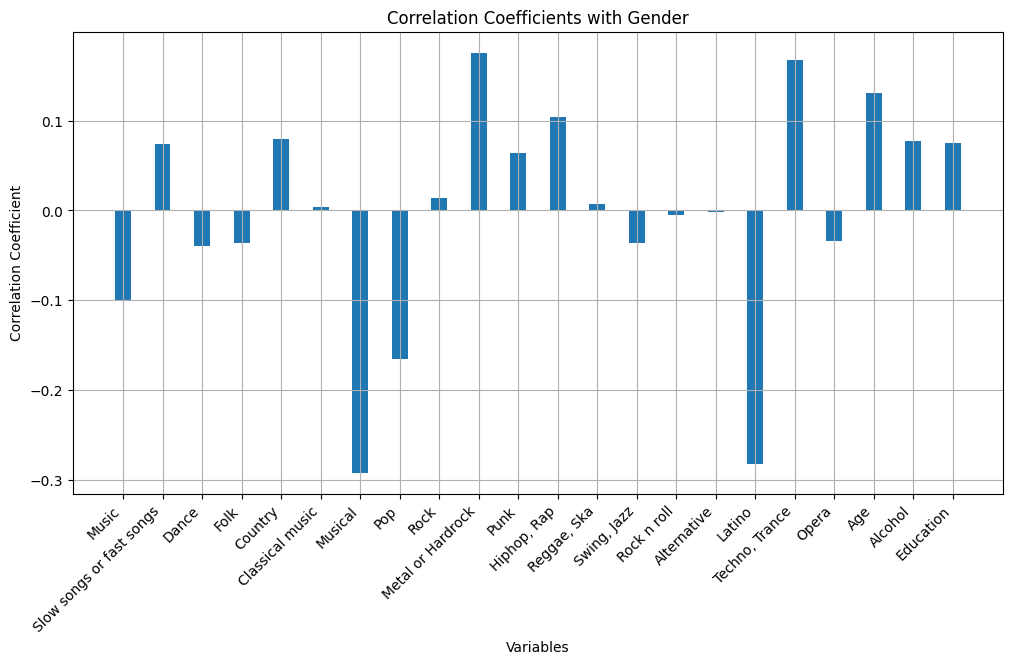

In [108]:
display_correlation_for_column(gender_correlation_matrix)

The chart indicates that women tend to prefer Latino, Musical, and Pop genres more. Additionally, men show a preference for Metal, Hard Rock, Hiphop, Rap, Techno, and Trance genres.


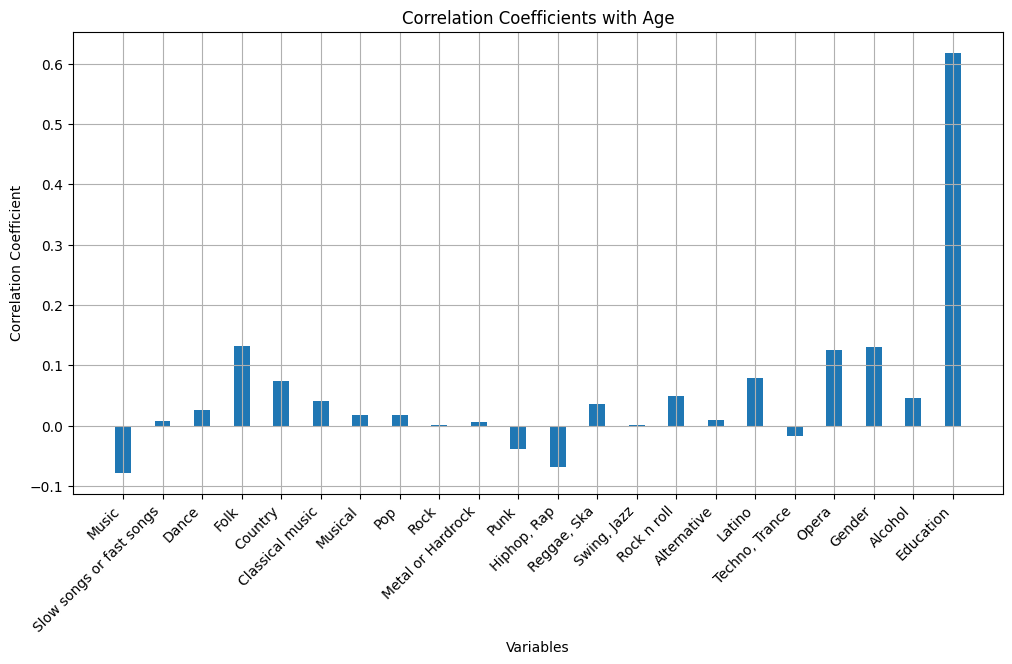

In [109]:
display_correlation_for_column(age_correlation_matrix)

The chart indicates that young tend to prefer Punk and Hiphop, Rap genres more. Additionally, old show a preference for Folk, Country, Latino, Opera genres.

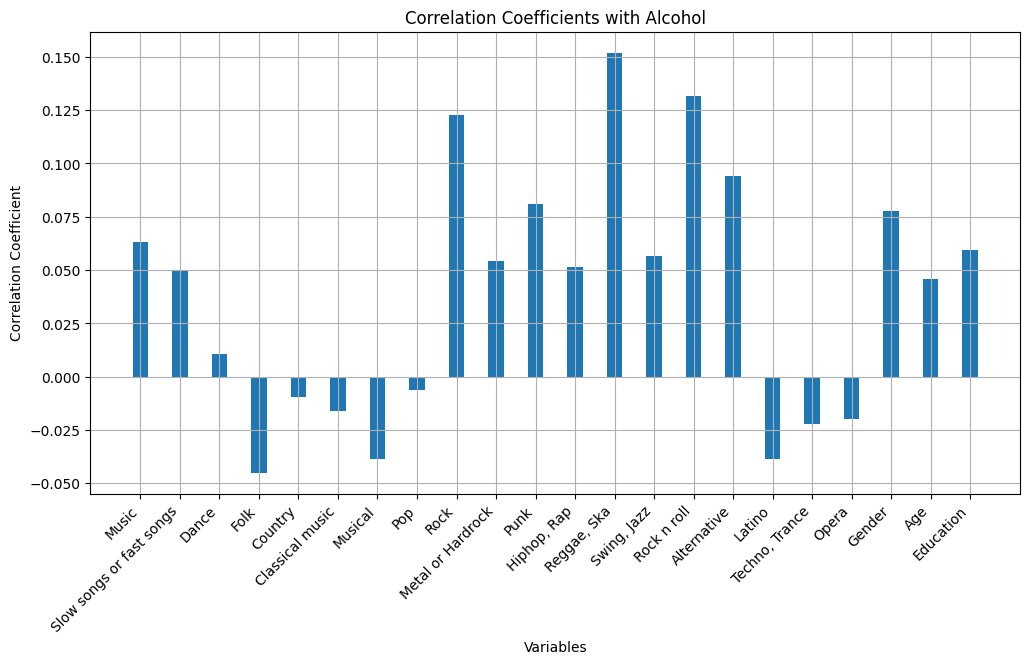

In [110]:
display_correlation_for_column(alcohol_correlation_matrix)

The chart indicates that people drinking alcohol more often tend to prefer Rage, Ska, Rock, Rock n roll genres more. Additionally, people drinking alcohol less preference for Folk, Musical, Latino genres.

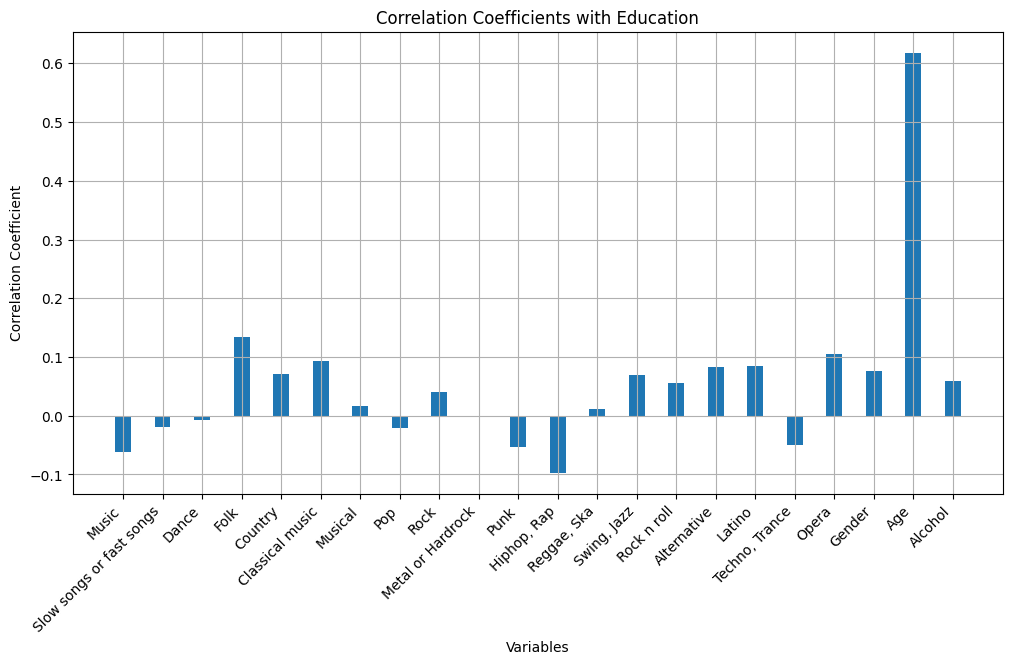

In [111]:
display_correlation_for_column(education_correlation_matrix)

The chart indicates that people with higer education more often tend to prefer Folk, Opera, genres more. Additionally, people wiht elementary edukation preference Hiphop, rap genres.

# Model Creating

check which model is most accurate for this type of data, repeat the test 100 times and take the average to get a more accurate result

In [128]:
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [
            np.mean([self.word2vec_model.wv[word] for word in document.split() if word in self.word2vec_model.wv] or [np.zeros(self.word2vec_model.vector_size)], axis=0)
            for document in X
        ]

columns_to_predict = ["Gender", "Age", "Alcohol", "Education"]
column = columns_to_predict[0]
num_features = df_music.shape[1] - 3
prime_numbers = generate_prime_numbers(num_features, num_features)
df_music_by_column = prepare_data(df_music, column, "music_data", prime_numbers)

word2vec_model = Word2Vec(sentences=df_music_by_column.music_data, vector_size=100, window=5, min_count=1, workers=4)
word2vec_vectorizer = Word2VecVectorizer(word2vec_model)

X_train, X_test, y_train, y_test = train_test_split(df_music_by_column.music_data, df_music_by_column[column], test_size=0.15, random_state=42)

classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=100000),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

vectorizers = [TfidfVectorizer(), word2vec_vectorizer]

results = {}

num_iterations = 100

for clf_name, classifier in classifiers.items():
    for vectorizer in vectorizers:
        acc_results = []
        cv_acc_results = []
        for _ in range(num_iterations):
            clf = Pipeline([
                ('vectorizer', vectorizer),
                ('classifier', classifier)
            ])

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            cv_accuracy = np.mean(cross_val_score(clf, df_music_by_column.music_data, df_music_by_column[column], cv=5, scoring='accuracy'))

            acc_results.append(accuracy)
            cv_acc_results.append(cv_accuracy)

        avg_accuracy = np.mean(acc_results)
        avg_cv_accuracy = np.mean(cv_acc_results)

        results[f'{clf_name} - {vectorizer.__class__.__name__}'] = {'avg_accuracy': avg_accuracy, 'avg_cv_accuracy': avg_cv_accuracy}

print("Results:")
for key, value in results.items():
    print(f"{key}: Average Accuracy - {value['avg_accuracy'] * 100:.2f}%, Average Cross-validated Accuracy - {value['avg_cv_accuracy'] * 100:.2f}%")


Results:
Random Forest - TfidfVectorizer: Average Accuracy - 68.76%, Average Cross-validated Accuracy - 68.03%
Random Forest - Word2VecVectorizer: Average Accuracy - 56.38%, Average Cross-validated Accuracy - 58.97%
Naive Bayes - TfidfVectorizer: Average Accuracy - 63.09%, Average Cross-validated Accuracy - 65.22%
Naive Bayes - Word2VecVectorizer: Average Accuracy - 56.38%, Average Cross-validated Accuracy - 58.97%
Support Vector Machine - TfidfVectorizer: Average Accuracy - 71.81%, Average Cross-validated Accuracy - 69.86%
Support Vector Machine - Word2VecVectorizer: Average Accuracy - 56.38%, Average Cross-validated Accuracy - 58.97%
Logistic Regression - TfidfVectorizer: Average Accuracy - 71.14%, Average Cross-validated Accuracy - 69.65%
Logistic Regression - Word2VecVectorizer: Average Accuracy - 56.38%, Average Cross-validated Accuracy - 58.97%
Gradient Boosting - TfidfVectorizer: Average Accuracy - 69.13%, Average Cross-validated Accuracy - 68.81%
Gradient Boosting - Word2VecVec

Results:

- Random Forest - TfidfVectorizer:
    - Average Accuracy: 68.76%
    - Average Cross-validated Accuracy: 68.03%

- Random Forest - Word2VecVectorizer:
    - Average Accuracy: 56.38%
    - Average Cross-validated Accuracy: 58.97%

- Naive Bayes - TfidfVectorizer:
    - Average Accuracy: 63.09%
    - Average Cross-validated Accuracy: 65.22%

- Naive Bayes - Word2VecVectorizer:
    - Average Accuracy: 56.38%
    - Average Cross-validated Accuracy: 58.97%

- Support Vector Machine - TfidfVectorizer:
    - Average Accuracy: 71.81%
    - Average Cross-validated Accuracy: 69.86%

- Support Vector Machine - Word2VecVectorizer:
    - Average Accuracy: 56.38%
    - Average Cross-validated Accuracy: 58.97%

- Logistic Regression - TfidfVectorizer:
    - Average Accuracy: 71.14%
    - Average Cross-validated Accuracy: 69.65%

- Logistic Regression - Word2VecVectorizer:
    - Average Accuracy: 56.38%
    - Average Cross-validated Accuracy: 58.97%

- Gradient Boosting - TfidfVectorizer:
    - Average Accuracy: 69.13%
    - Average Cross-validated Accuracy: 68.81%

- Gradient Boosting - Word2VecVectorizer:
    - Average Accuracy: 56.38%
    - Average Cross-validated Accuracy: 58.97%

- Decision Tree - TfidfVectorizer:
    - Average Accuracy: 57.92%
    - Average Cross-validated Accuracy: 58.41%

- Decision Tree - Word2VecVectorizer:
    - Average Accuracy: 56.38%
    - Average Cross-validated Accuracy: 58.97%

- K-Nearest Neighbors - TfidfVectorizer:
    - Average Accuracy: 70.47%
    - Average Cross-validated Accuracy: 62.29%

- K-Nearest Neighbors - Word2VecVectorizer:
    - Average Accuracy: 56.38%
    - Average Cross-validated Accuracy: 55.45%


The pair Logistic Regression - TfidfVectorizer have the best results among all models

### Use Logistic Regression and TfidfVectorizer to predict "Gender", "Age" "Alcohol" and "Education" base on music preferences

In [134]:
# Initialize Logistic Regression with specified parameters
logistic_regression = LogisticRegression(max_iter=100000)

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Create Pipeline with TfidfVectorizer and Logistic Regression
clf = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', logistic_regression)
])

columns_to_predict = ["Gender", "Age", "Alcohol", "Education"]

results = {}

num_features = df_music.shape[1] - 3
prime_numbers = generate_prime_numbers(num_features, num_features)

for column in columns_to_predict:

    df_music_by_column = prepare_data(df_music, column, "music_data", prime_numbers)

    accuracy_list = []
    cv_accuracy_list = []

    for _ in range(100):  # Repeat the process 100 times
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(df_music_by_column.music_data, df_music_by_column[column], test_size=0.15, random_state=42)

        # Fit the model
        clf.fit(X_train, y_train)

        # Predict the categories for the test set
        y_pred = clf.predict(X_test)

        # Calculate the accuracy of the model
        accuracy = accuracy_score(y_test, y_pred)

        # Calculate Cross-validated Accuracy
        cv_accuracy = np.mean(cross_val_score(clf, df_music_by_column.music_data, df_music_by_column[column], cv=5, scoring='accuracy'))

        accuracy_list.append(accuracy)
        cv_accuracy_list.append(cv_accuracy)

    # Calculate average accuracy and cross-validated accuracy
    avg_accuracy = np.mean(accuracy_list)
    avg_cv_accuracy = np.mean(cv_accuracy_list)

    # Add results to the dictionary
    results[column] = {'accuracy': avg_accuracy, 'cv_accuracy': avg_cv_accuracy}

# Print results
print("Results:")
for column, result in results.items():
    print(f"{column}: Logistic Regression - TfidfVectorizer: Average Accuracy - {result['accuracy'] * 100:.2f}%, Average Cross-validated Accuracy - {result['cv_accuracy'] * 100:.2f}%")

Results:
Gender: Logistic Regression - TfidfVectorizer: Average Accuracy - 71.14%, Average Cross-validated Accuracy - 69.65%
Age: Logistic Regression - TfidfVectorizer: Average Accuracy - 22.15%, Average Cross-validated Accuracy - 18.45%
Alcohol: Logistic Regression - TfidfVectorizer: Average Accuracy - 61.07%, Average Cross-validated Accuracy - 64.01%
Education: Logistic Regression - TfidfVectorizer: Average Accuracy - 63.09%, Average Cross-validated Accuracy - 60.49%


Results:
- Gender: Logistic Regression - TfidfVectorizer: Average Accuracy - 71.14%, Average Cross-validated Accuracy - 69.65%
- Age: Logistic Regression - TfidfVectorizer: Average Accuracy - 22.15%, Average Cross-validated Accuracy - 18.45%
- Alcohol: Logistic Regression - TfidfVectorizer: Average Accuracy - 61.07%, Average Cross-validated Accuracy - 64.01%
- Education: Logistic Regression - TfidfVectorizer: Average Accuracy - 63.09%, Average Cross-validated Accuracy - 60.49%
